In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

In [2]:
sys.path.insert(0,"/home/rzhu/Documents/nwn_l2l/")
from nwnTorch.misc import *

In [ ]:
"/home/rzhu/data_access/l2l_data/logs/LTL-NWN-learn_snn_new-SA/run-no-2023-04-06-190452/"

In [22]:
data_path = "/home/rzhu/data_access/l2l_data/logs/LTL-NWN-learn_snn-SA/run-no-2023-04-02-135654/"

fnames = os.listdir(data_path +"per_gen_trajectories")
fnames.sort()
n_gens = len(fnames)

In [23]:
results = []
for fn in fnames:
    fileName = os.path.join(data_path, "per_gen_trajectories", fn)
    temp = pkl_load(fileName)
    gen_out = torch.tensor([r[1][0] for r in temp.current_results])
    results.append(gen_out)

n_ins = len(gen_out)
results = torch.stack(results)

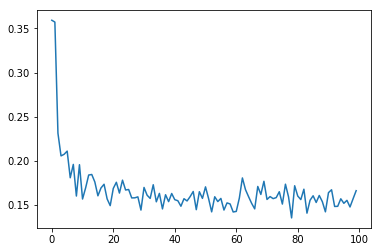

In [24]:
plt.plot(results.mean(axis = 1))

In [25]:
results.argmin(axis = 1)

tensor([ 4, 20,  6, 10,  8,  7,  6,  2, 19, 15, 21,  7, 14,  0,  4, 14,  7,  9,
        17,  1,  6,  1,  5,  5, 12, 21,  4, 23,  9, 23, 23, 20, 18,  1,  2,  8,
        21,  3, 23, 20,  2,  4,  5,  7,  1,  1,  8,  0,  1, 16,  5,  7, 20, 22,
        10, 23,  6, 22, 16, 12,  3, 11,  3,  9,  6,  8, 11, 11,  6,  6,  1,  2,
         6, 17,  4,  2, 20, 20, 15,  5,  1,  2,  6, 19, 11, 14, 22,  0,  8, 13,
        17,  8, 16,  1,  7, 13, 10, 19, 13, 11])

In [26]:
params = pkl_load(data_path+f"results/gen_{99:04d}_ind_{11:04d}.pkl")["params"]

In [27]:
sys.path.append("/home/rzhu/Documents/nwn_l2l/")
from nwnTorch.jn_models import *
from nwnTorch.nwn import *
from nwnTorch.generate_adj import *
from nwnTorch.misc import *

from tqdm import tqdm

In [28]:
def prepare_network(index = 0):
    snn_data_path = "/home/rzhu/data_access/l2l_data/snn_data_new/"
    adj = torch.tensor(pkl_load(snn_data_path + "con0.pkl")["adj_matrix"])
    net = NWN(adj, "sydney")

    net.params["Ron"]       = 1e4
    net.params["grow"]      = 5
    net.params["decay"]     = 10
    net.params["precision"] = True
    return net

In [29]:
snn_data_path = "/home/rzhu/data_access/l2l_data/snn_data_new/"
data_dict   = pkl_load(snn_data_path+f"snn_mem_{11}.pkl")
lambda_dict = pkl_load(snn_data_path+"lambda_data.pkl")

In [30]:
waves       = data_dict["waves"]
mems        = data_dict["mems"]
n_neurons   = mems.shape[-1]
num_inputs  = waves.shape[1]
num_steps   = waves.shape[0]
num_read    = 64

torch.manual_seed(0)
shuffled = torch.randperm(1024)
e_in     = shuffled[:num_inputs]
e_read   = shuffled[-num_read:]
readout  = torch.zeros(num_steps, num_read)

In [31]:
params

{'W_in': tensor([-0.0330, -0.2248,  0.1477,  0.3945, -0.4079, -0.0412,  0.1029,  0.5803,
          0.2758, -0.2565,  0.2834,  0.2994,  0.5725,  0.0690, -0.1110,  0.1808,
          0.1289,  0.4058,  0.2272,  0.2417]),
 'b_in': tensor([ 0.0792,  0.2421, -0.1630,  0.7288, -0.1313, -0.0436,  0.0932,  0.4223,
          0.2676,  0.5867,  0.2875, -0.4835,  0.2796, -0.1160, -0.1240, -0.1161,
         -0.3319, -0.2894,  0.0422, -0.1768]),
 'init_time': tensor(0.3592)}

In [36]:
net   = prepare_network()
W_in = params["W_in"] 
b_in = params["b_in"]
net.junction_state.L = lambda_dict["lambda"][360]

In [37]:
for i in tqdm(range(num_steps)):
    sig_in = W_in * waves[i] + b_in
    net.sim(sig_in.reshape(1,-1), e_in)
    readout[i,:] = net.V[e_read]

100%|██████████| 1000/1000 [00:07<00:00, 135.73it/s]


In [81]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel,RFECV
from sklearn.pipeline import Pipeline


# Always scale the input. The most convenient way is to use a pipeline.
# reg = make_pipeline(StandardScaler(),
#             linear_model.SGDRegressor(max_iter=10000000, tol=1e-1))
# reg = make_pipeline(StandardScaler(),
#             linear_model.RidgeCV())

In [84]:
train_range = torch.arange(0,800)
test_range  = torch.arange(800,1000)

predicts = []
# alphas = 10**np.linspace(-2,2,12)

for i in range(n_neurons):
    lhs = readout[:,:]
    rhs = mems[:,i]

    # weight, _, rcond = best_regress(lhs[train_range], rhs[train_range])
    # predict = weight @ lhs.T
    reg = make_pipeline(StandardScaler(),
                        linear_model.LinearRegression())
    
    reg.fit(lhs[train_range], rhs[train_range])
    predict = reg.predict(lhs)

    predicts.append(predict)
    print(mean_squared_error(predict[test_range], rhs[test_range]))
    # break
    # result[i] = get_RNMSE(predict, rhs)

239162.36638850492
6094.095271228991
3907.4192615292372
619.7612628052866
1171.8906225893445


Text(0, 0.5, 'Readout Neurons')

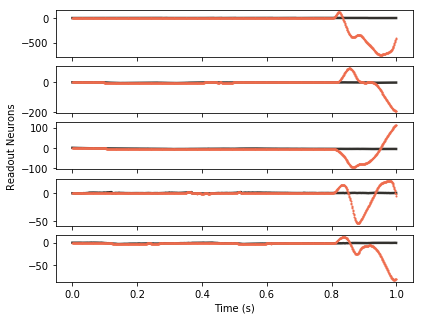

In [83]:
fig, axes = plt.subplots(5,1, figsize = (6.4, 5))

for i in range(5):
    axes[i].plot(np.arange(0,1,1e-3), mems[:,i], c = "#33312E", lw = 2.5,zorder = 1)
    # axes[i].scatter(np.arange(0,1,1e-3), play_dict0["predict"][:,i], c = "#5BC0BE", s = 1, zorder = 2)
    axes[i].scatter(np.arange(0,1,1e-3), predicts[i], c = '#EE6C4D', s = 1, zorder = 3)
    if i< 4: 
        axes[i].tick_params('x', labelbottom=False)


plt.xlabel("Time (s)")
axes[2].set_ylabel("Readout Neurons")